* * *
<pre> NYU Paris            <i> Artificial intelligence - Fall 2023 </i></pre>
* * *


<h1 align="center"> Lab 5: Model complexity and model selection </h1>

<pre align="left"> September 28th 2023               <i> Author: Julian Singer </i></pre>
* * *


##### Goals:
- Know when the model underfits and overfits and act accordingly
- Perform hyperparameter tuning using cross validation
- Use scikit-learn pipelines to streamline machine learning steps

## 1 - Reading and visualizing data 


First we load a dataset of images of famous persons and visualize some examples.

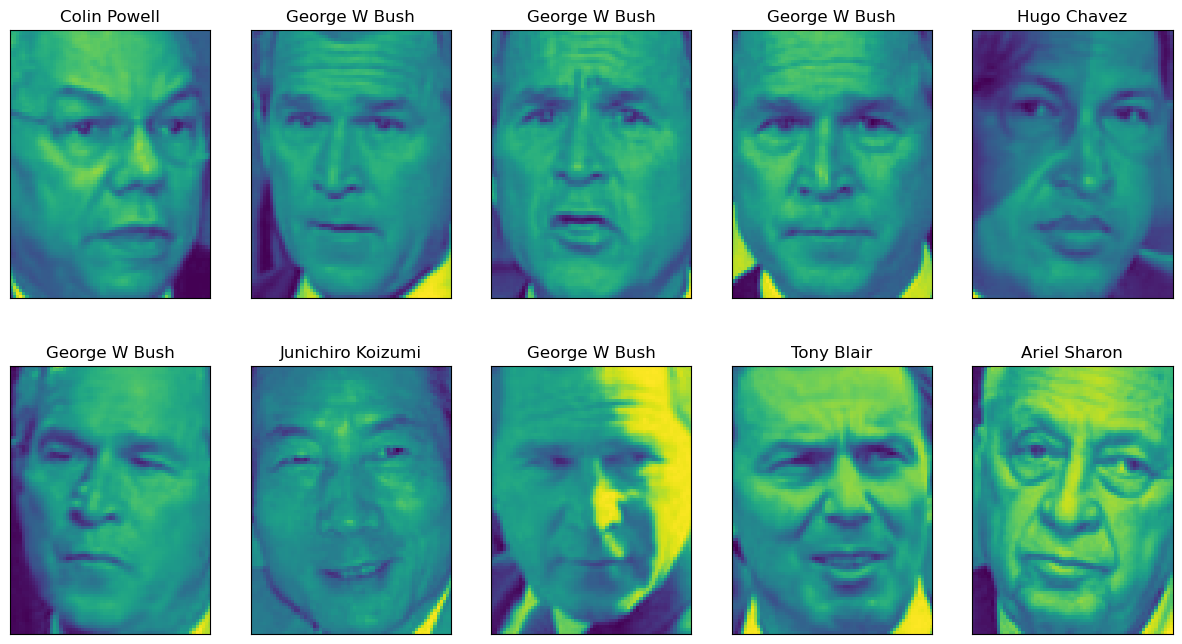

In [80]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt

people = fetch_lfw_people(min_faces_per_person=60, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])
    

Some information about the dataset can be obtained by getting the documentation of the fetch function:

In [81]:
help(fetch_lfw_people)

Help on function fetch_lfw_people in module sklearn.datasets._lfw:

fetch_lfw_people(*, data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)
    Load the Labeled Faces in the Wild (LFW) people dataset (classification).
    
    Download it if necessary.
    
    =================   =======================
    Classes                                5749
    Samples total                         13233
    Dimensionality                         5828
    Features            real, between 0 and 255
    =================   =======================
    
    Read more in the :ref:`User Guide <labeled_faces_in_the_wild_dataset>`.
    
    Parameters
    ----------
    data_home : str, default=None
        Specify another download and cache folder for the datasets. By default
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    funneled : boo

We print data shapes info:

In [82]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (1348, 87, 65)
Number of classes: 8


We have 62 different persons in the dataset with a total of 3023 images of shape (87x65).

### Question 0
Count how many each person appears in the dataset. 

Hint: Look up the function `np.bincount`

In [83]:
count = np.bincount(people.target) #we took only people with minimum 60 images when getting the dataset
count

array([ 77, 236, 121, 530, 109,  71,  60, 144])

We reshape the images the dataset to be of the form (n_samples x n_features)

In [84]:
X = people.images.reshape(len(people.images), -1)
y = people.target
X.min(), X.max(), X[0]

(0.0,
 1.0,
 array([0.5281046 , 0.52156866, 0.50980395, ..., 0.01045752, 0.00653595,
        0.00130719], dtype=float32))

The image values are between 0 and 255. We rescale them to 0-1.

In [85]:
#unneeded bc already scaled

#X = X / 255
#X.min(), X.max(), X[0]

### Question 1
Split the dataset into train and test (80% train). Look up the documentation of `train_test_split` to make sure the frequency of each label is respected in the splits. If you wrote a naive classifier that predicts the target of the person by picking a number randomly (uniformly). What would be its prediction score ? 

This would be our score baseline i.e the performance of chance.

In [86]:
import sklearn

In [87]:
from sklearn import model_selection
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=18, stratify=y)#, stratify = y)

__Answer:__
if all people had same number of images, a naive classifier would predict at random and the accuracy score would be 1/8 accuracy as 8 people are in the set and according to a naive classifier each would have the same chance of being predicted.


### Question 2

We start with making predictions with a K-nearest-neighbors (kNN) model. KNN predicts the target (the identity of the person) based on the majority vote of the target of the K closest images to it. Here we define "close" by computing a simple squared euclidean distance between the images.

Fit a k-NN with k [1, 2, 3, 4, 5] and compute its prediction score for train and test. How do you explain this result ? Does it overfit or underfit ?

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#GridSearchCV

def KNN_mdl(xtrain, xtest, ytrain, ytest):
    K=[1,2,3,4,5,10]
    scores=[]
    out=[]
    for k in K:
        KNN_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
        scores.append(k)
        for i in range(1,5):
            percentage_taken_marker = int((0.25*i)*len(xtrain))
            KNN_model.fit(xtrain[:percentage_taken_marker],ytrain[:percentage_taken_marker])
            train_pred = KNN_model.predict(xtrain)
            train_accuracy = accuracy_score(ytrain, train_pred)

            test_pred = KNN_model.predict(xtest)
            test_accuracy = accuracy_score(ytest, test_pred)
            scores.append([i * 0.25, train_accuracy, test_accuracy])
        out.append(scores)
        scores=[]
    return out



In [89]:
accuracies_by_percentage = KNN_mdl(xtrain, xtest, ytrain, ytest)

**Answer:** The model is overfitting, as when I print the training accuracy for all the k, I find that the training error is low and the test error is high, but the gap decreases as k increases, slowly approaching the minimum error and after it would underfit. When I test k=10, which I added for testing purposes, I find that the model performs poorly on both the test data and the training data, meaning it underfits, and thus the ideal number of neighbors for the components is less than 10, since in between the model switches from overfitting to underfitting

### Question 3
Display its train and test accuracy as a function of the number of train samples. Keep the number of test samples unchaned.

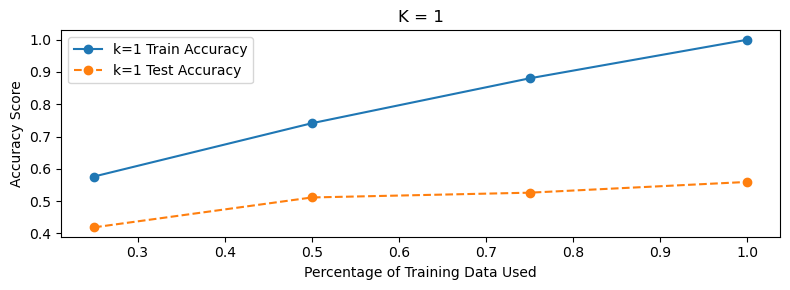

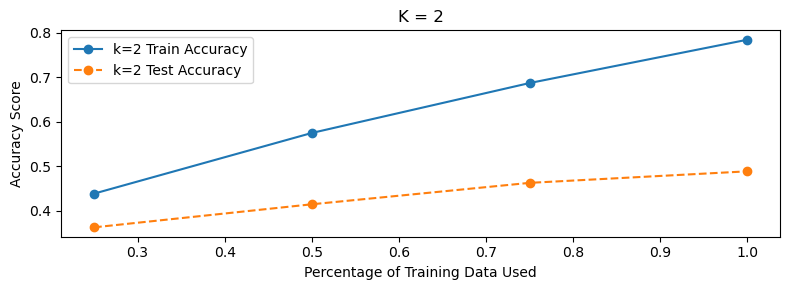

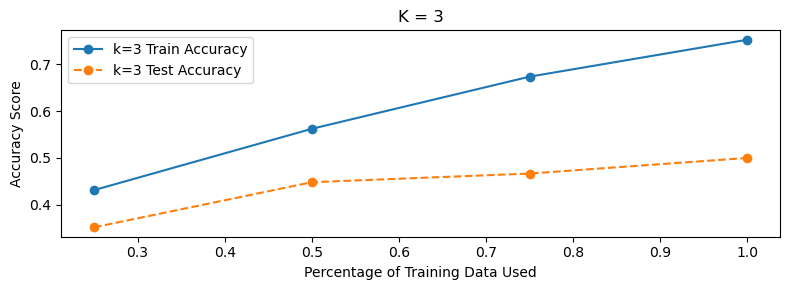

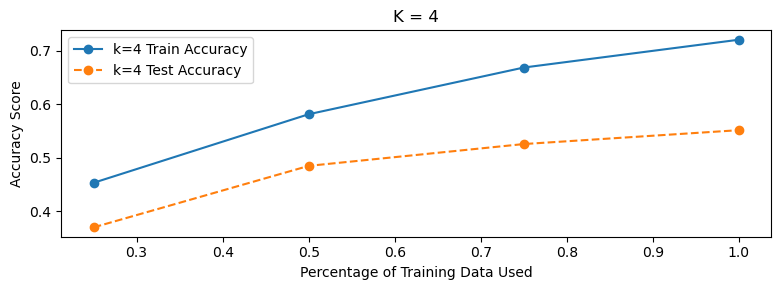

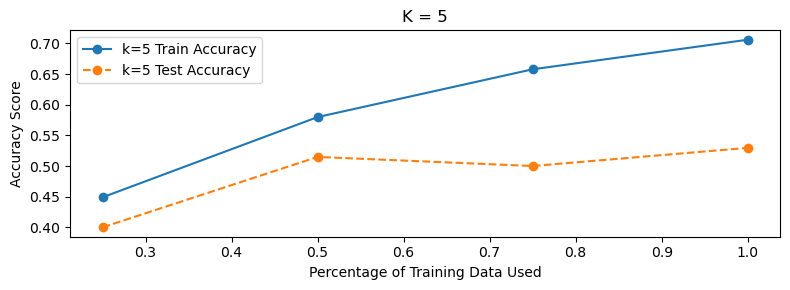

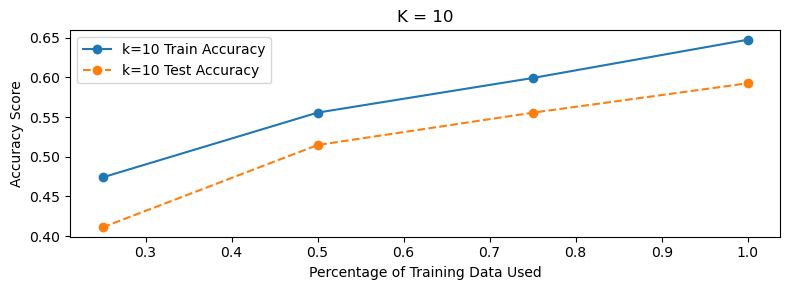

In [144]:
def print_accuracies(accuracies_by_percentage):
    first = True
    for i in accuracies_by_percentage:
        for ii in i:
            if first:
                print(f"k = {i[0]}")
                first = False
            else:
                print(f"At {int(ii[0]*100)}%: train accuracy: {ii[1]}, test accuracy: {ii[2]}")
        first = True

                
def plot_accuracies(accuracies_by_percentage):
    for idx, outer_array in enumerate(accuracies_by_percentage):
        all_train_acc = np.empty(0)
        all_test_acc = np.empty(0)
        all_percentages = np.empty(0)

        for inner_array in outer_array[1:]:
            all_percentages = np.append(all_percentages, inner_array[0])
            all_train_acc = np.append(all_train_acc, inner_array[1])
            all_test_acc = np.append(all_test_acc, inner_array[2])

        fig, ax = plt.subplots(figsize=(8, 3))

        ax.plot(all_percentages, all_train_acc, label=f'k={outer_array[0]} Train Accuracy', marker="o")
        ax.plot(all_percentages, all_test_acc, label=f'k={outer_array[0]} Test Accuracy', linestyle='dashed', marker="o")

        ax.set_xlabel('Percentage of Training Data Used')
        ax.set_ylabel('Accuracy Score')
        ax.legend()
        ax.set_title(f'K = {outer_array[0]}')

        plt.tight_layout()
        plt.show()
plot_accuracies(accuracies_by_percentage)

def compAccs(l1, l2, l3):
    print("Test accuracy comparison for the base data X, the pca of X, and the whitened pca of X")
    for a1, a2, a3 in zip(l1,l2,l3):
        c = a1[0]
        print(f"k={c}: base = {a1[3][2]:<20.6f} pca = {a2[3][2]:<20.6f} pcaW = {a3[3][2]:<20.6f}")


In [145]:
print_accuracies(accuracies_by_percentage)

k = 1
At 25%: train accuracy: 0.5760667903525046, test accuracy: 0.4185185185185185
At 50%: train accuracy: 0.7411873840445269, test accuracy: 0.5111111111111111
At 75%: train accuracy: 0.8803339517625232, test accuracy: 0.5259259259259259
At 100%: train accuracy: 1.0, test accuracy: 0.5592592592592592
k = 2
At 25%: train accuracy: 0.4387755102040816, test accuracy: 0.362962962962963
At 50%: train accuracy: 0.575139146567718, test accuracy: 0.4148148148148148
At 75%: train accuracy: 0.6873840445269017, test accuracy: 0.46296296296296297
At 100%: train accuracy: 0.7847866419294991, test accuracy: 0.4888888888888889
k = 3
At 25%: train accuracy: 0.4313543599257885, test accuracy: 0.35185185185185186
At 50%: train accuracy: 0.562152133580705, test accuracy: 0.44814814814814813
At 75%: train accuracy: 0.673469387755102, test accuracy: 0.4666666666666667
At 100%: train accuracy: 0.7523191094619666, test accuracy: 0.5
k = 4
At 25%: train accuracy: 0.4536178107606679, test accuracy: 0.3703703

### Question 4
Compute knn scores but this time do a PCA before to reduce the dimensionality of the data to 100 components

In [146]:
from sklearn.decomposition import PCA
pca = PCA(100)
pca.fit(xtrain)
X_pca_train = pca.transform(xtrain)
X_pca_test = pca.transform(xtest)

In [147]:
accuracies_by_percentage2 = KNN_mdl(X_pca_train, X_pca_test, ytrain, ytest)

print_accuracies(accuracies_by_percentage2)


k = 1
At 25%: train accuracy: 0.5705009276437848, test accuracy: 0.4148148148148148
At 50%: train accuracy: 0.7439703153988868, test accuracy: 0.4888888888888889
At 75%: train accuracy: 0.8840445269016698, test accuracy: 0.5185185185185185
At 100%: train accuracy: 1.0, test accuracy: 0.562962962962963
k = 2
At 25%: train accuracy: 0.44805194805194803, test accuracy: 0.35555555555555557
At 50%: train accuracy: 0.5825602968460112, test accuracy: 0.4148148148148148
At 75%: train accuracy: 0.6883116883116883, test accuracy: 0.45555555555555555
At 100%: train accuracy: 0.7801484230055659, test accuracy: 0.48518518518518516
k = 3
At 25%: train accuracy: 0.44990723562152135, test accuracy: 0.36666666666666664
At 50%: train accuracy: 0.5723562152133581, test accuracy: 0.4111111111111111
At 75%: train accuracy: 0.6808905380333952, test accuracy: 0.4703703703703704
At 100%: train accuracy: 0.7495361781076066, test accuracy: 0.5074074074074074
k = 4
At 25%: train accuracy: 0.4461966604823748, tes

### Question 5
Repeat this operation but set the PCA argument `whiten` to True. What do you notice ? How do you explain it ?

In [148]:
pcaWhiten = PCA(100, whiten=True)
pcaWhiten.fit(xtrain)
X_pca_trainWhiten = pcaWhiten.transform(xtrain)
X_pca_testWhiten = pcaWhiten.transform(xtest)

In [149]:
accuracies_by_percentage3 = KNN_mdl(X_pca_trainWhiten, X_pca_testWhiten, ytrain, ytest)
print_accuracies(accuracies_by_percentage3)

k = 1
At 25%: train accuracy: 0.6048237476808905, test accuracy: 0.45185185185185184
At 50%: train accuracy: 0.7736549165120594, test accuracy: 0.5259259259259259
At 75%: train accuracy: 0.9053803339517625, test accuracy: 0.6222222222222222
At 100%: train accuracy: 1.0, test accuracy: 0.6407407407407407
k = 2
At 25%: train accuracy: 0.5538033395176253, test accuracy: 0.43333333333333335
At 50%: train accuracy: 0.6530612244897959, test accuracy: 0.4703703703703704
At 75%: train accuracy: 0.7448979591836735, test accuracy: 0.5481481481481482
At 100%: train accuracy: 0.8293135435992579, test accuracy: 0.5777777777777777
k = 3
At 25%: train accuracy: 0.5111317254174397, test accuracy: 0.4185185185185185
At 50%: train accuracy: 0.6669758812615956, test accuracy: 0.5185185185185185
At 75%: train accuracy: 0.7662337662337663, test accuracy: 0.5851851851851851
At 100%: train accuracy: 0.8320964749536178, test accuracy: 0.6296296296296297
k = 4
At 25%: train accuracy: 0.5426716141001855, test a

In [150]:
compAccs(accuracies_by_percentage, accuracies_by_percentage2, accuracies_by_percentage3)

Test accuracy comparison for the base data X, the pca of X, and the whitened pca of X
k=1: base = 0.525926             pca = 0.518519             pcaW = 0.622222            
k=2: base = 0.462963             pca = 0.455556             pcaW = 0.548148            
k=3: base = 0.466667             pca = 0.470370             pcaW = 0.585185            
k=4: base = 0.525926             pca = 0.507407             pcaW = 0.600000            
k=5: base = 0.500000             pca = 0.514815             pcaW = 0.607407            
k=10: base = 0.555556             pca = 0.555556             pcaW = 0.585185            


**Answer:**
When I enable "whiten", the accuracy scores increase significantly. The reason for this is that whitening the data makes the variance for each component the same, and as such no single component has a greater influence than any other. 

### Question 6
Look up the attributes of the PCA object and visualize the first 10 components (as images).

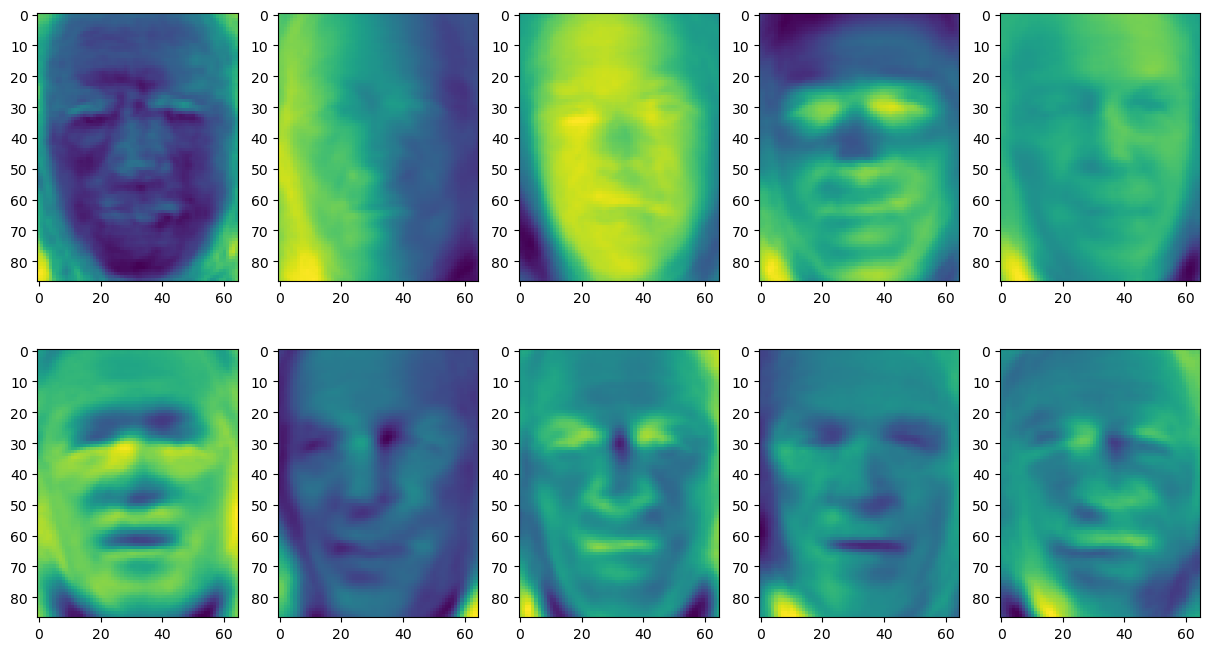

In [151]:
#print(pca.components_[:10])
figs, axes = plt.subplots(2, 5, figsize=(15,8))
count = 0
for i in range(0,2):
    for ii in range(0,5):
        axes[i][ii] .imshow(pca.components_[count].reshape(87,65))
        count+=1

### Question 7
We can automatize the choice of K by performing cross-validation:

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
params = {'n_neighbors': [2, 5, 6, 10]}
clf = GridSearchCV(model, params, cv=5, scoring='accuracy')
clf.fit(xtrain, ytrain)

y_pred = clf.best_estimator_.predict(xtest)

print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.50      0.43        16
           1       0.49      0.57      0.53        47
           2       0.53      0.38      0.44        24
           3       0.60      0.76      0.67       106
           4       0.44      0.18      0.26        22
           5       0.33      0.14      0.20        14
           6       0.36      0.33      0.35        12
           7       0.50      0.28      0.36        29

    accuracy                           0.53       270
   macro avg       0.46      0.39      0.40       270
weighted avg       0.51      0.53      0.51       270



You can look up the best performing model:

In [99]:
clf.best_estimator_

KNeighborsClassifier()

We would like to optimize over the choice of PCA n_components as well. To do this we 
 can streamline the PCA + classifier operation by creating a pipeline object. And pass it to the GridSearchCV object with key-coded parameters named like this:

In [100]:
from sklearn.pipeline import Pipeline

model = Pipeline([('pca', PCA()),
                  ('classifier', KNeighborsClassifier()
)])

params = {'pca__n_components': [100, 800], 'classifier__n_neighbors': [2,3,4,5,6]}

knnPCA = GridSearchCV(model, params, cv=5, scoring='accuracy')
knnPCA.fit(xtrain, ytrain)

y_pred = knnPCA.best_estimator_.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.50      0.43        16
           1       0.52      0.60      0.55        47
           2       0.67      0.50      0.57        24
           3       0.62      0.75      0.68       106
           4       0.33      0.23      0.27        22
           5       0.50      0.21      0.30        14
           6       0.56      0.42      0.48        12
           7       0.53      0.34      0.42        29

    accuracy                           0.56       270
   macro avg       0.51      0.44      0.46       270
weighted avg       0.55      0.56      0.54       270



What are the best choices of n_components and k ?

In [101]:
knnPCA.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=100)),
                ('classifier', KNeighborsClassifier())])

**Answer:**
After modifying the given code to reduce the max number of components to 800 in order to avoid the warning messages as discussed in class, I find that the best choice for n_components is 800, and the best choice for k is 2 since that is the only option given. When the given code is modified to include options for k=2, 3, 4, 5, 6 it results in the ideal number of neighbors being 5 and the number of components 100. I made this change because in the previous code block we find that the ideal number of neigbors is 5, and it made sense to modify this segment to also reflect that.

### Question 8
We move on to a different kind of model. We start with a simple linear classifier (LDA). 
Compute its performance (accuracy) with and without PCA. What do you notice ? Use a pipeline.

Interpret the results. What can you say about model complexity of LDA ? What should we do to improve the performance ?

In [102]:
#dont change solver unless you tune the shrinkage parameter if using cross validation
#if it takes too long to run reduce dimensions with PCA before to make it faster

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda.fit(xtrain,ytrain)
y_pred = lda.predict(xtest)
accuracy = accuracy_score(ytest, y_pred)
print(f"Accuracy without PCA: {accuracy * 100:.2f}%")


pca = PCA(n_components=100)
pipe = Pipeline([('pca', pca), ('lda', lda)])

pipe.fit(xtrain, ytrain)
y_pred_with_pca = pipeline_with_pca.predict(xtest)
accuracy_with_pca = accuracy_score(ytest, y_pred_with_pca)
print(f"Accuracy with PCA: {accuracy_with_pca * 100:.2f}%")



Accuracy without PCA: 71.11%
Accuracy with PCA: 82.96%


**Answer:**
The accuracy with PCA is significantly higher than without PCA, meaning that PCA reduces dimensions without losing much variance, and thus benefiting the linear model. Since LDA is linear, it is not very complex and can handle simpler data well. To further improve performance, optimizing the number of components in the PCA is a good idea since it was able to remove noise without eliminating important variance.

### Question 9
Repeat the operation with a random forest classifier. What do you notice ?

In [163]:
from sklearn.ensemble import RandomForestClassifier #slow with high parameters, use PCA to reduce dimensions first


rf1 = RandomForestClassifier()
rf1.fit(xtrain, ytrain)
y_pred = rf1.predict(xtest)
accuracy = accuracy_score(ytest, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


pca = PCA(n_components=100)
rf_clf_pca = RandomForestClassifier()
pipeline_with_pca_rf = Pipeline([('pca', pca), ('rf', rf_clf_pca)])
pipeline_with_pca_rf.fit(xtrain, ytrain)
y_pred_with_pca_rf = pipeline_with_pca_rf.predict(xtest)
accuracy_with_pca_rf = accuracy_score(ytest, y_pred_with_pca_rf)
print(f"Accuracy with PCA: {accuracy_with_pca_rf * 100:.2f}%")


Accuracy: 61.48%
Accuracy with PCA: 55.93%


**Answer:**
Enabling PCA lowers the accuracy score, thus it removed important dimensions to the data. As random forest randomly takes components to make its predictions, when removing some with PCA it reduces the options and eliminates critical factors in the model. The random forest model produces worse accuracy scores than the LDA model.

### Question 10
Look up its hyperparameters (`min_samples_leaf`, `n_estimators`, `max_depth` etc). Tune the values of these these hyperparameters using GridSearchCV. Can you beat the LDA method ?

In [142]:
from sklearn.model_selection import RandomizedSearchCV
mdl = RandomForestClassifier()
paramsRF = {
    'n_estimators': [50,100,250,500],
    'criterion':["gini","entropy","log_loss"],
    'max_depth': [None, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomizedSearchCV(mdl, paramsRF, cv=5, scoring="accuracy")
rf.fit(X_pca_train, ytrain)
ypred = rf.best_estimator_.predict(X_pca_test)

print(rf.best_estimator_)
print(rf.best_params_)
print(rf.best_score_)

RandomForestClassifier(criterion='entropy', max_depth=100, max_features=None,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=250)
{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 100, 'criterion': 'entropy'}
0.6345391903531439


**Answer:**
The hyperparameter tuning results in a moderate improvement, but the random forest classifier is still well short of the LDA. When using additional hyperparameters, my accuracy decreased significantly, this combination produced the best result though it did not match or beat the LDA method.

### Question 11
GradientBoosting methoda are optimized versions of RandomForests where trees are added to the forest sequentially by picking "optimal" trees to add. Optimize their hyperparameters and compare with random forests.

In [129]:
from sklearn.ensemble import HistGradientBoostingClassifier

mdlHGB = HistGradientBoostingClassifier()
paramsHGB = {
    'max_leaf_nodes': [50,100,150,200],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_leaf': [1,2,5,10],
    'max_iter': [50,100,250,500]
}
hgb = RandomizedSearchCV(mdlHGB, paramsHGB, cv=5, scoring="accuracy")
hgb.fit(X_pca_train, ytrain)
ypred = hgb.best_estimator_.predict(X_pca_test)

print(hgb.best_estimator_)
print(hgb.best_params_)
print(hgb.best_score_)

HistGradientBoostingClassifier(max_depth=30, max_iter=250, max_leaf_nodes=200,
                               min_samples_leaf=10)
{'min_samples_leaf': 10, 'max_leaf_nodes': 200, 'max_iter': 250, 'max_depth': 30}
0.7124289405684754


**Answer:**
The HistGradientBoostingClassifier() boosts the accuracy compared to the random forests that were optimized in question 10 by around 6%, changing when I rerun the entirety of the file and see different portions of the data used for training and test. Using other parameters resulted in lower accuracy scores, so I left them out and got my best results using these parameters.